# import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

# review

`-` 데이터 셋팅

In [20]:
# code-fold : true
tnp.random.seed(41068)
N = 200
x = tnp.linspace(0,1,N)
epsilon = tnp.random.randn(N)*0.5
y = 2.5 + 4*x + epsilon
y_hat = 2.5 + 4*x

`-`  이전까지 최적해를 찾을 때는 아래처럼 수식을 알고 있어야 한다는 단점이 있다.

$$\text{loss} = \left(\frac {1}{2}-\beta \right)^2$$

`-` 보통 `loss`함수의 경우 위와 같이 간단한 형태로 정의되는 것이 아닌 비모수적 형태, 즉, 함수의 형태를 가정할 수가 없는 경우가 대부분임.

* `tf.keras.optimizers`를 이용한다면 `loss`함수가 비모수적이어도 비교적 쉽게  최적해를 찾을 수 있다.

* 위 식을 최소로하는 $\hat {\beta} = 2$ 이다. 이전까지 이를 구하는 과정은 다음과 같았다.

`-` 회귀분석 예제

$$\hat  y = 4x + 2.5$$

$$\hat {\beta}_1 =4, \,\, \hat {\beta}_0  = 2.5 $$

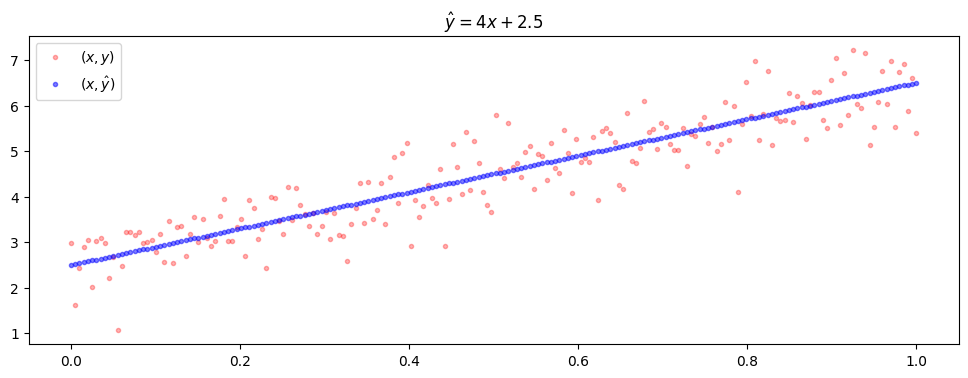

In [21]:
#| code-fold : true
plt.figure(figsize  = (12,4))
plt.plot(x,y,".r", label = r"$(x,y)$",alpha = 0.3 )
plt.plot(x,y_hat,".b", label = r"$(x,\hat y)$",alpha = 0.5)
plt.title(r"$\hat  y = 4x +2.5$")
plt.legend()
plt.show()

`-` loss

$$\text{loss} = \bf(y-X \hat{\beta})^{\top}(y-X\hat {\beta})$$

$$ \bf{X} \hat {\beta} = \bf {\hat {y}}$$

`-` 기존 방식(경사하강법을 이용한 풀이)

In [22]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
beta_hat = tf.Variable([-5.0,10.0]) ## 초기값 셋
alpha=0.1

$$\beta_{t+1} = \beta_{t} - \alpha \times \frac {d\,\text{loss}}{d\, \beta}$$

In [23]:
for epoc in range(1000):
    with tf.GradientTape() as tape:
        tape.watch(beta_hat)
        yhat = X@beta_hat
        loss = (y-yhat).T @ (y-yhat) / N
    slope = tape.gradient(loss,beta_hat)
    beta_hat.assign_sub(slope * alpha)

In [24]:
beta_hat

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([2.5205595, 3.924182 ], dtype=float32)>

# `tf.keras.optimizers`

## SGD : 확률적 경사하강법

In [25]:
beta_hat = tf.Variable([-5.0,10.0]) ## 초기값 셋
alpha = 0.1
opt = tf.keras.optimizers.SGD(alpha) ## 경사하강법 종류 선언

In [26]:
for epoc in range(1000):
    with tf.GradientTape() as tape:
        yhat = X@beta_hat
        loss = (y-yhat).T @ (y-yhat) / N
    slope = tape.gradient(loss,beta_hat)
    opt.apply_gradients( [(slope,beta_hat),(slope,beta_hat)] )

In [27]:
beta_hat

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([2.5205617, 3.9241781], dtype=float32)>

## SGD + opt.minimize

`-` opt.minimize $\to$ slope + `beta_assign_sub`

`-` 셋팅

In [28]:
y=y.reshape(N,1)
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [29]:
beta_hat = tf.Variable(tnp.array([-5.0,10.0]).reshape(2,1))

`-` loss 함수 정의

In [30]:
def loss_fn():
    return (y-X@beta_hat).T @ (y-X@beta_hat)/N

In [31]:
alpha=0.1
opt = tf.optimizers.SGD(alpha)

In [32]:
for epoc in range(1000):
    opt.minimize(loss_fn,[beta_hat]) # 미분 + update

In [33]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.52055998],
       [3.92418141]])>

## net($\star\star\star$)

In [34]:
N = 200
alpha=0.1
opt=tf.optimizers.SGD(alpha) ## 옵티마이저의 선택

$$y = ax +b$$

$$y = X\beta$$

In [40]:
## 포인트코드1: 네트워크 생성
net = tf.keras.Sequential() ## step1. net을 뭐 순차적으로 만들겠다.

## 포인트코드2: 네트워크의 아키텍처 설계
net.add(tf.keras.layers.Dense(1,input_shape=(2,),use_bias=False))

## 포인트코드3: 네트워크 컴파일 = 손실함수 + 옵티마이저
net.compile(opt,loss=tf.losses.MeanSquaredError())

In [41]:
## 포인트코드4: 미분 & update
net.fit(X,y,epochs=1000,verbose=0,batch_size=N)

In [42]:
net.weights

[<tf.Variable 'dense_1/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[2.5205722],
        [3.924159 ]], dtype=float32)>]

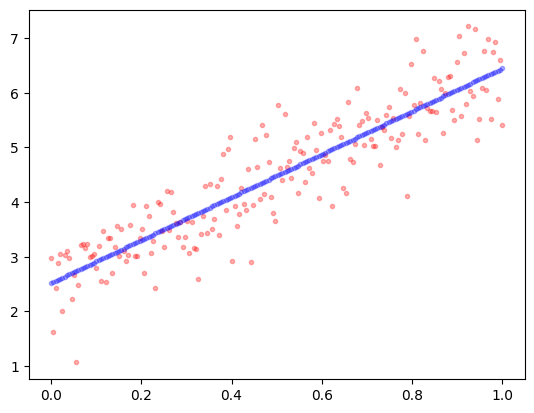

In [48]:
plt.plot(x,y, ".r",alpha= 0.3)
plt.plot(x,2.5205722 + 3.924159*x, ".b",alpha= 0.3)

In [49]:
net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
